
# 01 — LPT basics: painting and spectra

Build Gaussian initial conditions, run first-order LPT, paint flat/spherical maps, and inspect spectra using the library plot helpers.


In [2]:
import os
os.environ["JAX_ENABLE_X64"] = "False"
os.environ["JAX_PLATFORM_NAME"] ='cpu'
os.environ["JAX_PLATFORMS"] = 'cpu'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

from fwd_model_tools import gaussian_initial_conditions
from fwd_model_tools.pm import lpt


In [3]:
# Tiny configuration for speed
key = jax.random.PRNGKey(0)
mesh_size = (256, 256, 256)
box_size = (600.0, 600.0, 600.0)
nside = 256
flatsky_npix = (256, 256)
flat_field_size = (10, 10)
cosmo = jc.Planck15()

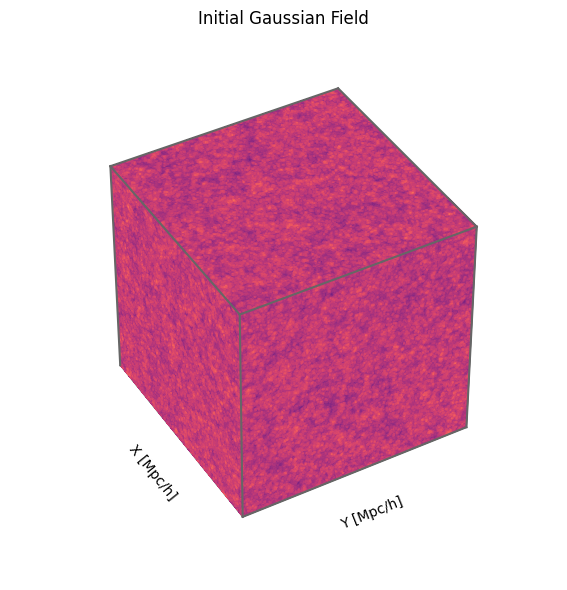

In [4]:

# 1) Gaussian initial field (pk_fn left None to use default)
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo, nside=nside, flatsky_npix=flatsky_npix, field_size=flat_field_size
)
initial_field.show(labels=["X [Mpc/h]", "Y [Mpc/h]", ""] , colorbar=False , titles=["Initial Gaussian Field"])

In [5]:
# 2) First-order LPT displacements/

max_a = jc.background.a_of_chi(cosmo , initial_field.max_comoving_radius).squeeze()

a_edges = jnp.linspace(0.98 , max_a , 5)
a_near = a_edges[:-1]
a_far = a_edges[1:]
a_center = 0.5 * (a_near + a_far)
scale_factor = jnp.stack([a_near , a_far] , axis=1)
scale_factor = a_center
print(f"a_center are {a_center}")

spherical_dens, _ = lpt(cosmo, initial_field, scale_factor_spec=scale_factor, order=1 , geometry='spherical')
flat_dens, _ = lpt(cosmo, initial_field, scale_factor_spec=scale_factor, order=1 , geometry='flat')
density3d, _ = lpt(cosmo, initial_field, scale_factor_spec=scale_factor, order=1 , geometry='density')
ptcl , _ = lpt(cosmo, initial_field, scale_factor_spec=scale_factor, order=1 , geometry='particles')

a_center are [0.97084257 0.95252771 0.93421285 0.91589799]


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/fields/lightcone.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/fields/density.py:278: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/fields/particles.py:555: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_236429/1884567953.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


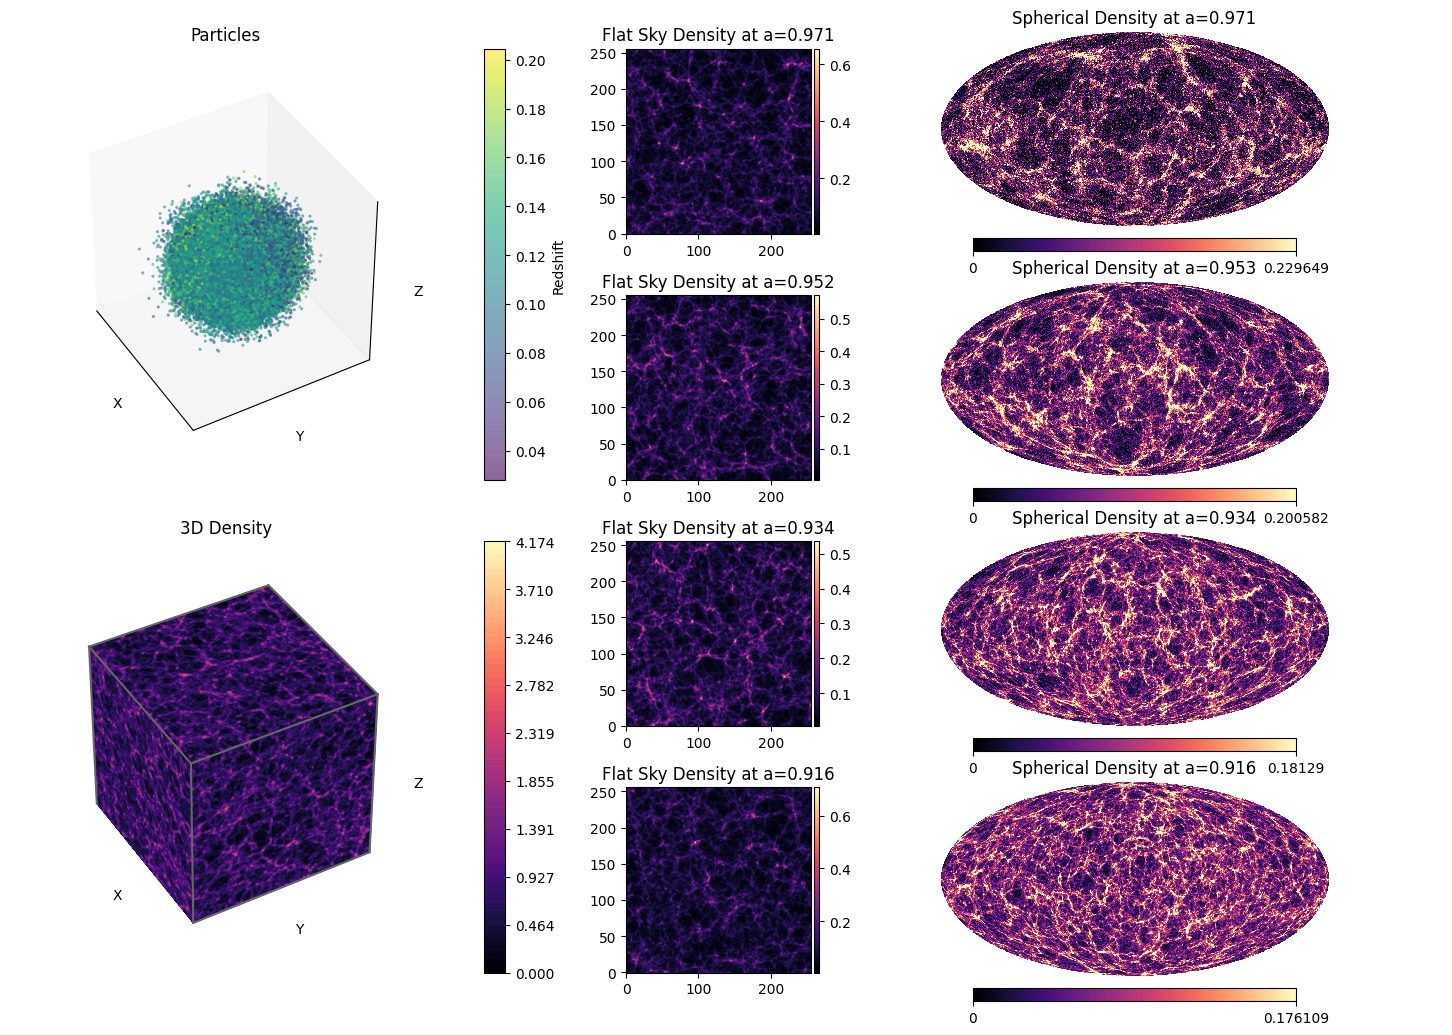

In [6]:
figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(4, 3 , width_ratios=[1, 1, 0.5])
ax_part3d = figure.add_subplot(gs[0:2, 0], projection='3d')
ax_dens3d = figure.add_subplot(gs[2:4, 0], projection='3d')
ax_flat = [figure.add_subplot(gs[i, 1]) for i in range(4)]
ax_sphere = [figure.add_subplot(gs[i, 2]) for i in range(4)]

spherical_dens.plot(ax=ax_sphere , titles=[f'Spherical Density at a={a:.3f}' for a in a_center])
flat_dens.plot(ax=ax_flat)
density3d.apply_fn(jnp.log1p).plot(ax=ax_dens3d,colorbar=True)
ptcl.plot(ax=ax_part3d , weights='z',colorbar=True)
plt.tight_layout()
plt.show()


In [23]:
def compute_theory_cl(spherical_dens):
    """Compute theoretical C_ell using Limber approximation (ℓ≥2)."""
    print("Computing theoretical C_ell with Limber approximation...")
    from jax.tree_util import register_pytree_node_class
    from jax_cosmo.redshift import redshift_distribution

    @register_pytree_node_class
    class tophat_z(redshift_distribution):
        def pz_fn(self, z):
            zmin, zmax = self.params
            return jnp.where((z >= zmin) & (z <= zmax), 1.0, 0.0)

    # Create cosmology (using same parameters as simulation)
    cosmo_th = cosmo

    cl_theory_list = []
    LMAX = 3 * nside
    ell_theory = jnp.arange(0, LMAX + 1)

    for r , width in zip(spherical_dens.comoving_centers , spherical_dens.density_width):
        R_min = r - 0.5 * width
        R_max = r + 0.5 * width
    
        # Convert comoving distances to redshifts for shell limits
        a_min = jc.background.a_of_chi(cosmo_th, R_min).squeeze()
        a_max = jc.background.a_of_chi(cosmo_th, R_max).squeeze()
        zmin = float(jc.utils.a2z(a_min))
        zmax = float(jc.utils.a2z(a_max))
        
        print(f"   Shell at r = {r:.1f} Mpc/h:")
        print(f"   Distance shell: [{R_min:.1f}, {R_max:.1f}] Mpc/h")
        print(f"   Redshift range: z ∈ [{zmin:.3f}, {zmax:.3f}]")
        
        # Top-hat redshift window and unit bias (galaxy clustering, no RSD)
        nz = tophat_z(zmin, zmax, gals_per_arcmin2=1.0)
        bias = jc.bias.constant_linear_bias(1.0)
        probe = jc.probes.NumberCounts([nz], bias, has_rsd=False)
        
        # Setup integration grid and compute C_ell
        ell_theory = jnp.arange(0, LMAX + 1)
        cl_theory = jc.angular_cl.angular_cl(cosmo_th, ell_theory, [probe], nonlinear_fn=jc.power.linear).squeeze()
    
        cl_theory_list.append(cl_theory)

    return ell_theory , jnp.stack(cl_theory_list , axis=0)


theory_ell , theory_cl = compute_theory_cl(spherical_dens)


Computing theoretical C_ell with Limber approximation...
   Shell at r = 89.6 Mpc/h:
   Distance shell: [60.4, 118.8] Mpc/h
   Redshift range: z ∈ [0.020, 0.040]
   Shell at r = 148.0 Mpc/h:
   Distance shell: [118.3, 177.6] Mpc/h
   Redshift range: z ∈ [0.040, 0.060]
   Shell at r = 208.1 Mpc/h:
   Distance shell: [177.6, 238.5] Mpc/h
   Redshift range: z ∈ [0.060, 0.081]
   Shell at r = 269.7 Mpc/h:
   Distance shell: [238.9, 300.5] Mpc/h
   Redshift range: z ∈ [0.081, 0.103]


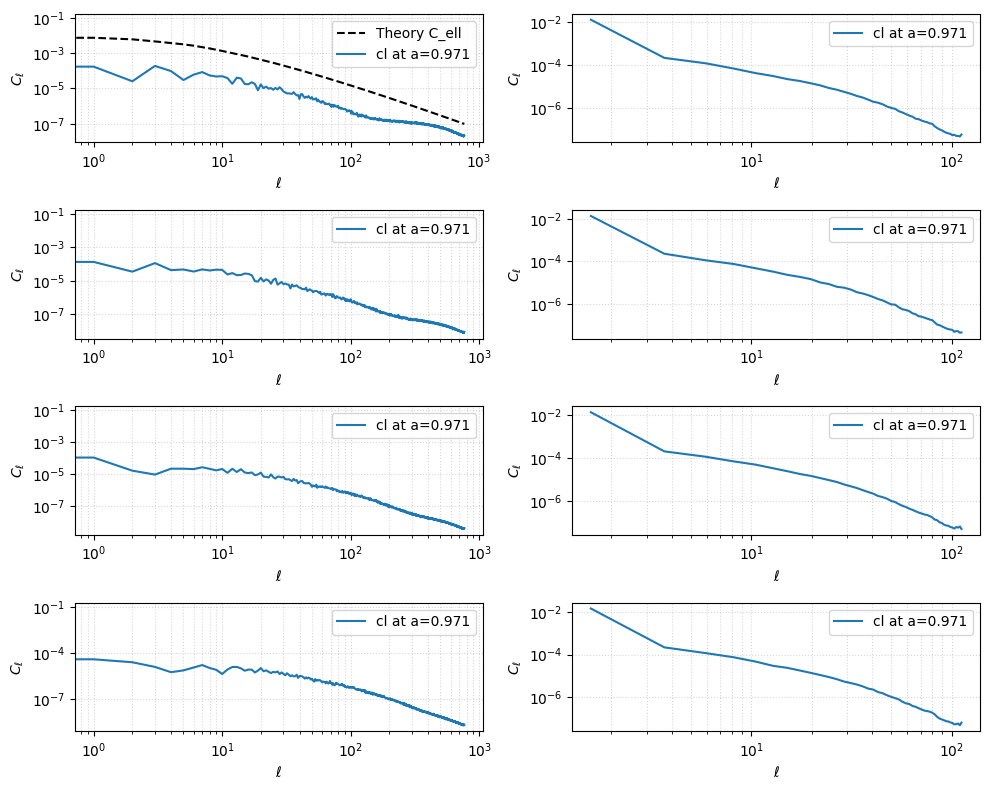

In [31]:
from fwd_model_tools.power import PowerSpectrum

theory_cl_ps = PowerSpectrum(wavenumber=theory_ell, spectra=theory_cl[0] , name='th')

figure = plt.figure(figsize=(10, 8))
gs = figure.add_gridspec(4, 2 , width_ratios=[1, 1])
ax_cl_sphere = [figure.add_subplot(gs[i, 0]) for i in range(4)]
ax_cl_flat = [figure.add_subplot(gs[i, 1]) for i in range(4)]
cl_sphere = spherical_dens.angular_cl(method="healpy")
cl_flat = flat_dens.angular_cl()

theory_cl_ps.plot(ax=ax_cl_sphere[0] , logx=True , logy=True , label=['Theory C_ell'] , color='black' , linestyle='--' )

for i in range(4):
    cl_flat[i].plot(ax=ax_cl_flat[i] , logx=True , logy=True)
    cl_sphere[i].plot(ax=ax_cl_sphere[i] , logx=True , logy=True)

plt.tight_layout()
plt.show()

In [ ]:
spherical_dens, _ = lpt(cosmo, initial_field, scale_factor_spec=scale_factor, order=1 , geometry='spherical' , kwargs={'scheme' : 'rbf_neighbor', 'kernel_width_arcmin' : 10 } )


ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class 'dict'>, {'scheme': 'rbf_neighbor', 'kernel_width_arcmin': 10}. The error was:
TypeError: unhashable type: 'dict'
